In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [3]:
import multiprocessing

import pandas as pd
import datamol as dm
import numpy as np
import seaborn as sns

from molfeat.calc import RDKitDescriptors2D, FPCalculator, MordredDescriptors
from molfeat.trans import MoleculeTransformer
from sklearn.preprocessing import OneHotEncoder

import collections.abc as collections
from molfeat.trans.concat import FeatConcat

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from src.config import mem
from src.utils import embed3d, eval_model, OffsetScaler
from src.descriptors import get_dgl_predictions, get_hft_predictions, get_3d_predictions, get_2d_predictions

from rdkit import RDLogger, Chem
RDLogger.DisableLog('rdApp.*')

In [4]:
train = dm.read_csv('../data/processed/train.csv', smiles_column='smi', index_col=0)[:5]
test = dm.read_csv('../data/processed/test.csv', smiles_column='smi', index_col=0)[:5]

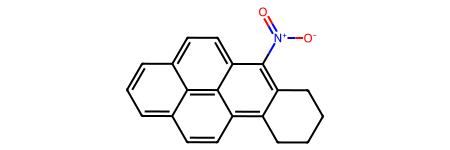

In [5]:
train.mol[0]

In [6]:
from molfeat.trans.fp import FPVecTransformer

from molfeat.trans.pretrained import PretrainedDGLTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

ADD_3D_FEATS = False

feats2D_params = [
    # fps
    {'kind': 'ecfp:4', 'length': 1024},
    {'kind': 'maccs', 'length': 167},
    {'kind': 'topological', 'length': 1024},
    {'kind': 'avalon', 'length': 1024},
    {'kind': 'erg', 'length': 315},
    {'kind': 'layered', 'length': 1024},
    {'kind': 'secfp', 'length': 1024},
    {'kind': 'pattern', 'length': 1024},
    {'kind': 'pharm2D', 'n_jobs': -1, 'length': 1024},
    
    # normalize
    {'kind': 'estate', 'length': 79},
    {'kind': 'desc2D', 'n_jobs': -1, 'length': 216, 'replace_nan': True},
    {'kind': 'mordred', 'n_jobs': -1, 'length': 1613},
    {'kind': 'cats2D', 'n_jobs': -1, 'length': 189, 'replace_nan': True},
    {'kind': 'scaffoldkeys', 'n_jobs': -1, 'length': 42, 'replace_nan': True},
    {'kind': 'skeys', 'n_jobs': -1, 'length': 42, 'replace_nan': True},
]


feat3D_params = [
    {'kind': 'desc3D', 'length': 639, 'replace_nan': True},
    {'kind': 'cats3D', 'length': 126, 'replace_nan': True},
    {'kind': 'pharm3D', 'length': 1024, },
    {'kind': 'electroshape', 'length': 15, 'replace_nan': True},
    {'kind': 'usr', 'length': 12},
    {'kind': 'usrcat', 'length': 60},
]


dgl_params = [
    {'kind': 'gin_supervised_contextpred', 'n_jobs': -1},
    {'kind': 'gin_supervised_infomax', 'n_jobs': -1},
    {'kind': 'gin_supervised_edgepred', 'n_jobs': -1},
    {'kind': 'gin_supervised_masking', 'n_jobs': -1},
]

hft_params = [
    {'kind': 'MolT5', 'notation': 'smiles', 'random_seed': 42, 'device': 'cuda'},
    {'kind': 'GPT2-Zinc480M-87M', 'notation': 'smiles', 'random_seed': 42, 'device': 'cuda'},
    {'kind': 'Roberta-Zinc480M-102M', 'notation': 'smiles', 'random_seed': 42, 'device': 'cuda'},    
]

# featurizer = FeatConcat(transformers, dtype=np.float32)

# calcucalte feats and cache them
for params in feats2D_params:
    print(params)
    mem.cache(get_2d_predictions, ignore=['n_jobs', 'dtype'])(train.smi, **params)
    mem.cache(get_2d_predictions, ignore=['n_jobs', 'dtype'])(test.smi, **params)
        
for params in dgl_params:
    print(params)
    mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(train.smi, **params)
    mem.cache(get_dgl_predictions, ignore=['n_jobs', 'dtype'])(test.smi, **params)

if ADD_3D_FEATS:
    mols3d = embed3d(train.smi, n_confs=1)
        
    
    for params in feat3D_params:
        print(params)
        mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(train.smi, **params)
        mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(test.smi, **params)
    
    
# for params in hft_params:
#     feats = mem.cache(get_hft_predictions, ignore=['n_jobs', 'dtype', 'device'])(train.smi, params, device='cpu', n_jobs=-1)
    
# for kind, params in hft_params.items():
#     print('Initializing', end=' ')    
#     trans = PretrainedHFTransformer(kind, **params, n_jobs=-1)
#     print(kind, end=' ')
#     feats = mem.cache(trans.transform)(train.smi)
#     print(feats.shape[1])

{'kind': 'ecfp:4', 'length': 1024}
{'kind': 'maccs', 'length': 167}
{'kind': 'topological', 'length': 1024}
{'kind': 'avalon', 'length': 1024}
{'kind': 'erg', 'length': 315}
{'kind': 'layered', 'length': 1024}
{'kind': 'secfp', 'length': 1024}
{'kind': 'pattern', 'length': 1024}
{'kind': 'pharm2D', 'n_jobs': -1, 'length': 1024}
{'kind': 'estate', 'length': 79}
{'kind': 'desc2D', 'n_jobs': -1, 'length': 216, 'replace_nan': True}
{'kind': 'mordred', 'n_jobs': -1, 'length': 1613}
{'kind': 'cats2D', 'n_jobs': -1, 'length': 189, 'replace_nan': True}
{'kind': 'scaffoldkeys', 'n_jobs': -1, 'length': 42, 'replace_nan': True}
{'kind': 'skeys', 'n_jobs': -1, 'length': 42, 'replace_nan': True}
{'kind': 'gin_supervised_contextpred', 'n_jobs': -1}
{'kind': 'gin_supervised_infomax', 'n_jobs': -1}
{'kind': 'gin_supervised_edgepred', 'n_jobs': -1}
{'kind': 'gin_supervised_masking', 'n_jobs': -1}


In [29]:
smiles = test[:3].smi.copy()

In [30]:
res = embed3d(smiles)
res

[None,

In [31]:
from Auto3D import auto3D

mols3d = pd.Series(res, index=smiles.index)

failed_smiles = smiles[mols3d.isna()]
args = auto3D.options(k=1, use_gpu=True, verbose=True)
mols3d.loc[failed_smiles.index] = auto3D.smiles2mols(failed_smiles, args)


Checking input file...
	There are 1 SMILES in the input file /tmp/tmp322_e8le/smiles.smi. 
	All SMILES and IDs are valid.
Suggestions for choosing isomer_engine and optimizing_engine: 
	Isomer engine options: RDKit and Omega.
	Optimizing engine options: ANI2x, ANI2xt, AIMNET or your own NNP.
Enumerating cis/tran isomers for unspecified double bonds...
Enumerating R/S isomers for unspecified atomic centers...
Removing enantiomers...
Enumerating conformers/rotamers, removing duplicates...


100%|██████████| 2/2 [00:10<00:00,  5.23s/it]


Preparing for parallel optimizing... (Max optimization steps: 5000)
Total 3D conformers: 24


 10%|▉         | 499/5000 [00:39<05:55, 12.68it/s]

Total 3D structures: 24  Converged: 17   Dropped(Oscillating): 0    Active: 7


 19%|█▉        | 963/5000 [01:11<05:00, 13.42it/s]

Optimization finished at step 964:   Total 3D structures: 24  Converged: 24   Dropped(Oscillating): 0    Active: 0
Begin to select structures that satisfy the requirements...


Energy unit: Hartree if implicit.


In [74]:
for params in feat3D_params:        
    print(params)
    feats = mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(train.smi, n_confs=2, **params)
    print('train', feats.shape)
    feats = mem.cache(get_3d_predictions, ignore=['n_jobs', 'dtype'])(test.smi, **params)
    print('test', len(feats) if isinstance(feats, list) else feats.shape)

{'kind': 'desc3D', 'length': 639, 'replace_nan': True}
________________________________________________________________________________
[Memory] Calling src.descriptors.get_3d_predictions...
get_3d_predictions(id
0                                                        O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2
1    O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c(ccc5c(=O)c6ccccc6c(=O)c54)c3c12
2                                                                           [N-]=[N+]=CC(=O)NCC(=O)NN
3                                                                           [N-]=[N+]=C1C=NC(=O)NC1=O
4                                                           CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O
Name: smi, dtype: object, n_confs=2, kind='desc3D', length=639, replace_nan=True)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 639 and the array at index 1 has size 5

In [ ]:
ohe = OneHotEncoder(sparse_output=False)

def get_x_train(feats):
    return np.concatenate([feats, ohe.fit_transform(train[["prop"]])], axis=1)

def get_x_test(feats):
    return np.concatenate([feats, ohe.transform(train[["test"]])], axis=1)

# Correlation

In [18]:
from src.utils import get_fps_offset, get_fps_cols
from src.corr import non_corr_ids, get_corr, non_corr_features

fps_offset = get_fps_offset(X_train.columns)
descs_target = pd.concat([X_train.iloc[:, fps_offset:], y_train], axis=1)
corr = mem.cache(get_corr)(descs_target)

ids = non_corr_ids(corr, threshold=0.95)

In [29]:
X_train.shape

(7939, 3682)

In [30]:
non_corr_features(X_train, y_train, threshold=0.95).shape

(7939, 3111)

1340


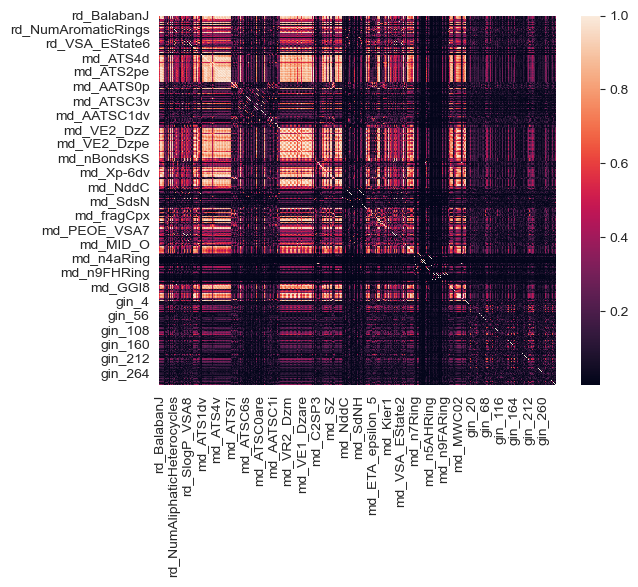

In [25]:
print(len(corr.columns))
sns.heatmap(corr.abs());

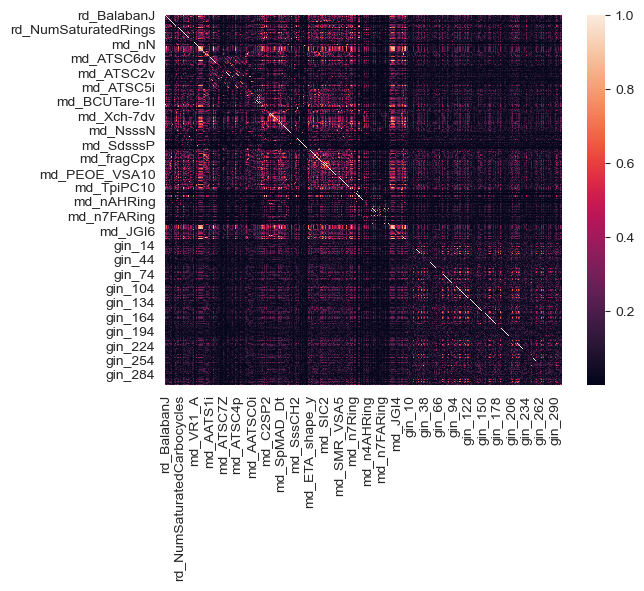

In [26]:
sns.heatmap(corr.iloc[ids, ids].abs());

In [14]:
fps_cols = get_fps_cols(X_train.columns)
uncorr_cols = corr.columns[ids].tolist()

X_train_uncorr = X_train[fps_cols + uncorr_cols].copy()
X_train_uncorr.shape

(7939, 3112)

In [28]:
X_test_uncorr = X_test[fps_cols + uncorr_cols].copy()
X_test_uncorr.shape

(1221, 3112)

In [29]:
X_train_uncorr.to_pickle('../data/processed/X_train_uncorr.pkl.zip')
X_test_uncorr.to_pickle('../data/processed/X_test_uncorr.pkl.zip')

# full uncorrellated

In [30]:
descs_target = pd.concat([X_train, y_train], axis=1)
corr = mem.cache(get_corr)(descs_target)

ids = non_corr_ids(corr, threshold=0.95)
uncorr_cols = corr.columns[ids].tolist()

len(uncorr_cols), X_train_uncorr.shape[1]

(3111, 3112)

In [31]:
# X_train_uncorr_all = X_train[uncorr_cols].copy()
# X_test_uncorr_all = X_test[uncorr_cols].copy()

In [32]:
# X_train_uncorr_all.shape

In [33]:
# X_train_uncorr_all.to_pickle('../data/processed/X_train_uncorr_all.pkl.zip')
# X_test_uncorr_all.to_pickle('../data/processed/X_test_uncorr_all.pkl.zip')

In [34]:
# len(fps_cols), len(get_fps_cols(X_train_uncorr_all.columns))